In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import numpy as np
import RNA
from environment import RNAInvEnvironment
from matplotlib import pyplot as plt

In [62]:
objective_structure = '(((((((((((((((.(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).)))))))))))))))'
objective_structure = '(((((......)))))'
objective_structure = '(((((((....(((...........)))((((((((..(((((((((((((((((((...(((((......))))).)))))).)))))))))))))..))))))))..)))))))'

In [63]:
env = RNAInvEnvironment(objective_structure, max_steps=100)

In [64]:
env.action_space

MultiDiscrete([6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4])

In [65]:
env.observation_space

Dict(0:Discrete(6), 1:Discrete(6), 10:Discrete(4), 100:Discrete(6), 101:Discrete(6), 102:Discrete(6), 103:Discrete(6), 104:Discrete(6), 105:Discrete(6), 106:Discrete(6), 107:Discrete(4), 108:Discrete(4), 109:Discrete(6), 11:Discrete(6), 110:Discrete(6), 111:Discrete(6), 112:Discrete(6), 113:Discrete(6), 114:Discrete(6), 115:Discrete(6), 12:Discrete(6), 13:Discrete(6), 14:Discrete(4), 15:Discrete(4), 16:Discrete(4), 17:Discrete(4), 18:Discrete(4), 19:Discrete(4), 2:Discrete(6), 20:Discrete(4), 21:Discrete(4), 22:Discrete(4), 23:Discrete(4), 24:Discrete(4), 25:Discrete(6), 26:Discrete(6), 27:Discrete(6), 28:Discrete(6), 29:Discrete(6), 3:Discrete(6), 30:Discrete(6), 31:Discrete(6), 32:Discrete(6), 33:Discrete(6), 34:Discrete(6), 35:Discrete(6), 36:Discrete(4), 37:Discrete(4), 38:Discrete(6), 39:Discrete(6), 4:Discrete(6), 40:Discrete(6), 41:Discrete(6), 42:Discrete(6), 43:Discrete(6), 44:Discrete(6), 45:Discrete(6), 46:Discrete(6), 47:Discrete(6), 48:Discrete(6), 49:Discrete(6), 5:Discre

In [66]:
done = False
obs = env.reset()
print(obs)
rewards = []
while not done:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)

{'0': 0, '1': 0, '2': 1, '3': 3, '4': 2, '5': 2, '6': 3, '7': 2, '8': 1, '9': 2, '10': 3, '11': 0, '12': 3, '13': 2, '14': 2, '15': 2, '16': 1, '17': 0, '18': 3, '19': 1, '20': 2, '21': 2, '22': 2, '23': 3, '24': 0, '25': 1, '26': 0, '27': 3, '28': 1, '29': 1, '30': 0, '31': 1, '32': 1, '33': 0, '34': 1, '35': 0, '36': 1, '37': 1, '38': 2, '39': 1, '40': 0, '41': 1, '42': 0, '43': 0, '44': 3, '45': 3, '46': 1, '47': 1, '48': 1, '49': 0, '50': 1, '51': 1, '52': 0, '53': 0, '54': 3, '55': 1, '56': 1, '57': 0, '58': 3, '59': 2, '60': 1, '61': 2, '62': 2, '63': 0, '64': 3, '65': 2, '66': 0, '67': 2, '68': 3, '69': 1, '70': 1, '71': 0, '72': 3, '73': 1, '74': 1, '75': 2, '76': 2, '77': 0, '78': 2, '79': 0, '80': 1, '81': 1, '82': 0, '83': 2, '84': 0, '85': 3, '86': 0, '87': 2, '88': 2, '89': 0, '90': 0, '91': 1, '92': 1, '93': 2, '94': 1, '95': 0, '96': 1, '97': 0, '98': 3, '99': 3, '100': 0, '101': 1, '102': 2, '103': 2, '104': 3, '105': 0, '106': 2, '107': 2, '108': 1, '109': 0, '110': 1,

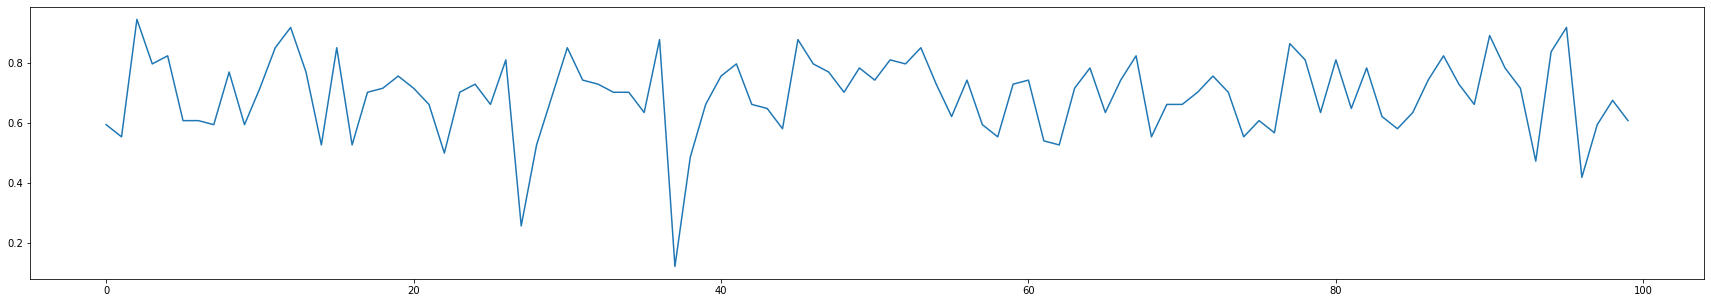

In [57]:
plt.figure(figsize=(30,5))
plt.plot(rewards)

In [25]:
len(rewards)

1000

In [26]:
rewards

[0.4594594594594595,
 0.9054054054054054,
 0.6486486486486487,
 0.7972972972972973,
 0.581081081081081,
 0.6621621621621622,
 0.7027027027027027,
 0.7162162162162162,
 0.6756756756756757,
 0.581081081081081,
 0.7162162162162162,
 0.6081081081081081,
 0.7567567567567568,
 0.5,
 0.5540540540540541,
 0.7297297297297297,
 0.7162162162162162,
 0.7702702702702703,
 0.5675675675675675,
 0.6486486486486487,
 0.7297297297297297,
 0.8108108108108109,
 0.8513513513513513,
 0.6756756756756757,
 0.6756756756756757,
 0.6756756756756757,
 0.6621621621621622,
 0.6351351351351351,
 0.6891891891891891,
 0.6351351351351351,
 0.581081081081081,
 0.6891891891891891,
 0.8513513513513513,
 0.7837837837837838,
 0.8108108108108109,
 0.581081081081081,
 0.5945945945945946,
 0.7432432432432432,
 0.581081081081081,
 0.7162162162162162,
 0.6621621621621622,
 0.6216216216216216,
 0.47297297297297297,
 0.7297297297297297,
 0.6216216216216216,
 0.6486486486486487,
 0.8108108108108109,
 0.7972972972972973,
 0.82432432